# 14장 모델의 성능 향상시키기

[<img src="https://raw.githubusercontent.com/taehojo/taehojo.github.io/master/assets/images/linktocolab.png" align="left"/> ](https://colab.research.google.com/github/taehojo/deeplearning/blob/master/colab/ch14-colab.ipynb)

## 데이터의 확인과 검증셋

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import pandas as pd

# 데이터를 입력합니다.
df = pd.read_csv('./data/wine.csv', header=None)

# 데이터를 미리 보겠습니다.
df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0


In [2]:
# 와인의 속성을 X로 와인의 분류를 y로 저장합니다.
X = df.iloc[:,0:12]
y = df.iloc[:,12]

In [3]:
#학습셋과 테스트셋으로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# 모델 구조를 설정합니다.
model = Sequential()
model.add(Dense(30,  input_dim=12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

#모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델을 실행합니다.
history=model.fit(X_train, y_train, epochs=50, batch_size=500, validation_split=0.25) # 0.8 x 0.25 = 0.2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                390       
_________________________________________________________________
dense_1 (Dense)              (None, 12)                372       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 875
Trainable params: 875
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
8/8 [==============================] - 1s 23ms/step - loss: 2.9423 - accuracy: 0.7519 - val_loss: 2.2360 - val_accuracy: 0.7562
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 2.0859 - accuracy: 0.76 - 0s 6ms/step - loss: 1.774

In [4]:
# 테스트 결과를 출력합니다.
score=model.evaluate(X_test, y_test)
print('Test accuracy:', score[1])

41/41 [==============================] - 0s 1ms/step - loss: 0.1438 - accuracy: 0.9415
Test accuracy: 0.9415384531021118


## 2. 모델 업데이트하기

### 기본 코드 불러오기

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터를 입력합니다.
df = pd.read_csv('./data/wine.csv', header=None)

# 와인의 속성을 X로 와인의 분류를 y로 저장합니다.
X = df.iloc[:,0:12]
y = df.iloc[:,12]

#학습셋과 테스트셋으로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# 모델 구조를 설정합니다.
model = Sequential()
model.add(Dense(30,  input_dim=12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

#모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                390       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                372       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 875
Trainable params: 875
Non-trainable params: 0
_________________________________________________________________


### 모델의 저장 설정 및 실행

In [6]:
# 모델 저장의 조건을 설정합니다.
modelpath="./data/model/all/{epoch:02d}-{val_accuracy:.4f}.keras"
checkpointer = ModelCheckpoint(filepath=modelpath, verbose=1)

# 모델을 실행합니다. 
history=model.fit(X_train, y_train, epochs=50, batch_size=500, validation_split=0.25, verbose=0, callbacks=[checkpointer])


Epoch 00001: saving model to ../data/model/all\01-0.7646.hdf5

Epoch 00002: saving model to ../data/model/all\02-0.7646.hdf5

Epoch 00003: saving model to ../data/model/all\03-0.7646.hdf5

Epoch 00004: saving model to ../data/model/all\04-0.7646.hdf5

Epoch 00005: saving model to ../data/model/all\05-0.7646.hdf5

Epoch 00006: saving model to ../data/model/all\06-0.7646.hdf5

Epoch 00007: saving model to ../data/model/all\07-0.8669.hdf5

Epoch 00008: saving model to ../data/model/all\08-0.8900.hdf5

Epoch 00009: saving model to ../data/model/all\09-0.9031.hdf5

Epoch 00010: saving model to ../data/model/all\10-0.9031.hdf5

Epoch 00011: saving model to ../data/model/all\11-0.9085.hdf5

Epoch 00012: saving model to ../data/model/all\12-0.9131.hdf5

Epoch 00013: saving model to ../data/model/all\13-0.9177.hdf5

Epoch 00014: saving model to ../data/model/all\14-0.9215.hdf5

Epoch 00015: saving model to ../data/model/all\15-0.9277.hdf5

Epoch 00016: saving model to ../data/model/all\16-0.92

In [7]:
# 테스트 결과를 출력합니다.
score=model.evaluate(X_test, y_test)
print('Test accuracy:', score[1])

41/41 [==============================] - 0s 2ms/step - loss: 0.1686 - accuracy: 0.9392
Test accuracy: 0.939230740070343


## 3. 그래프로 과적합 확인하기

In [8]:
# 그래프 확인을 위한 긴 학습 (컴퓨터 환경에 따라 시간이 다소 걸릴수 있습니다)
history=model.fit(X_train, y_train, epochs=2000, batch_size=500, verbose=0, validation_split=0.25) 

In [9]:
# history에 저장된 학습 결과를 확인해 보겠습니다. 
hist_df=pd.DataFrame(history.history)
hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.147854,0.947395,0.163222,0.938462
1,0.146364,0.948165,0.161854,0.940769
2,0.145011,0.947909,0.160797,0.940000
3,0.144104,0.947909,0.158959,0.946154
4,0.142609,0.948935,0.159250,0.940769
...,...,...,...,...
1995,0.030691,0.992045,0.071841,0.983077
1996,0.030978,0.992558,0.070400,0.985385
1997,0.030977,0.992045,0.074907,0.985385
1998,0.032843,0.990762,0.078405,0.984615


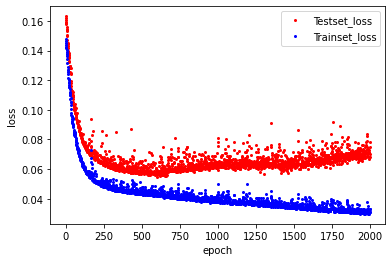

In [10]:
# y_vloss에 테스트셋(여기서는 검증셋)의 오차를 저장합니다.
y_vloss=hist_df['val_loss']

# y_loss에 학습셋의 오차를 저장합니다.
y_loss=hist_df['loss']

# x 값을 지정하고 테스트셋(검증셋)의 오차를 빨간색으로, 학습셋의 오차를 파란색으로 표시합니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, "o", c="red", markersize=2, label='Testset_loss')
plt.plot(x_len, y_loss, "o", c="blue", markersize=2, label='Trainset_loss')

plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 4. 학습의 자동 중단

### 기본 코드 불러오기

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import pandas as pd

# 데이터를 입력합니다.
df = pd.read_csv('./data/wine.csv', header=None)

# 와인의 속성을 X로 와인의 분류를 y로 저장합니다.
X = df.iloc[:,0:12]
y = df.iloc[:,12]

#학습셋과 테스트셋으로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# 모델 구조를 설정합니다.
model = Sequential()
model.add(Dense(30,  input_dim=12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

#모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 30)                390       
_________________________________________________________________
dense_9 (Dense)              (None, 12)                372       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 875
Trainable params: 875
Non-trainable params: 0
_________________________________________________________________


### 학습의 자동 중단 및 최적화 모델 저장

In [12]:
# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/Ch14-4-bestmodel.keras"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

#모델을 실행합니다.
history=model.fit(X_train, y_train, epochs=2000, batch_size=500, validation_split=0.25, verbose=1, callbacks=[early_stopping_callback,checkpointer], verbose=0) #verbose=1 진행 화면 출력, verbose=0 진행 화면 출력 안함.


Epoch 1/2000
8/8 [==============================] - 0s 18ms/step - loss: 21.4771 - accuracy: 0.2494 - val_loss: 14.8183 - val_accuracy: 0.2462
Epoch 2/2000
8/8 [==============================] - 0s 5ms/step - loss: 11.2518 - accuracy: 0.2494 - val_loss: 7.2853 - val_accuracy: 0.2462
Epoch 3/2000
8/8 [==============================] - 0s 5ms/step - loss: 4.9423 - accuracy: 0.2476 - val_loss: 1.8426 - val_accuracy: 0.2200
Epoch 4/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.7835 - accuracy: 0.6074 - val_loss: 0.3719 - val_accuracy: 0.8031
Epoch 5/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.4234 - accuracy: 0.8004 - val_loss: 0.4128 - val_accuracy: 0.8092
Epoch 6/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.4370 - accuracy: 0.8163 - val_loss: 0.3641 - val_accuracy: 0.8300
Epoch 7/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.3622 - accuracy: 0.8399 - val_loss: 0.2913 - val_accuracy: 0.8692
Epoch 8/2000
8/8

8/8 [==============================] - 0s 5ms/step - loss: 0.1041 - accuracy: 0.9664 - val_loss: 0.0917 - val_accuracy: 0.9715
Epoch 118/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.1027 - accuracy: 0.9646 - val_loss: 0.0965 - val_accuracy: 0.9723
Epoch 119/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.1030 - accuracy: 0.9654 - val_loss: 0.0916 - val_accuracy: 0.9731
Epoch 120/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.1021 - accuracy: 0.9659 - val_loss: 0.0908 - val_accuracy: 0.9723
Epoch 121/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.1014 - accuracy: 0.9648 - val_loss: 0.0928 - val_accuracy: 0.9746
Epoch 122/2000
8/8 [==============================] - 0s 6ms/step - loss: 0.1014 - accuracy: 0.9666 - val_loss: 0.0926 - val_accuracy: 0.9738
Epoch 123/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.1004 - accuracy: 0.9669 - val_loss: 0.0910 - val_accuracy: 0.9754
Epoch 124/2000
8/8 [=

Epoch 175/2000
8/8 [==============================] - 0s 6ms/step - loss: 0.0798 - accuracy: 0.9723 - val_loss: 0.0766 - val_accuracy: 0.9792
Epoch 176/2000
8/8 [==============================] - 0s 6ms/step - loss: 0.0789 - accuracy: 0.9743 - val_loss: 0.0774 - val_accuracy: 0.9792
Epoch 177/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0791 - accuracy: 0.9733 - val_loss: 0.0779 - val_accuracy: 0.9777
Epoch 178/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0809 - accuracy: 0.9743 - val_loss: 0.0786 - val_accuracy: 0.9792
Epoch 179/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0804 - accuracy: 0.9749 - val_loss: 0.0811 - val_accuracy: 0.9777
Epoch 180/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0797 - accuracy: 0.9749 - val_loss: 0.0759 - val_accuracy: 0.9785
Epoch 181/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0780 - accuracy: 0.9736 - val_loss: 0.0759 - val_accuracy: 0.9792
Epoch 

Epoch 233/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0655 - accuracy: 0.9777 - val_loss: 0.0760 - val_accuracy: 0.9762
Epoch 234/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0747 - accuracy: 0.9738 - val_loss: 0.0866 - val_accuracy: 0.9746
Epoch 235/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0759 - accuracy: 0.9710 - val_loss: 0.0723 - val_accuracy: 0.9808
Epoch 236/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0686 - accuracy: 0.9777 - val_loss: 0.0687 - val_accuracy: 0.9800
Epoch 237/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0638 - accuracy: 0.9787 - val_loss: 0.0685 - val_accuracy: 0.9808
Epoch 238/2000
8/8 [==============================] - 0s 6ms/step - loss: 0.0628 - accuracy: 0.9772 - val_loss: 0.0684 - val_accuracy: 0.9800
Epoch 239/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0626 - accuracy: 0.9792 - val_loss: 0.0687 - val_accuracy: 0.9808
Epoch 

Epoch 291/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0575 - accuracy: 0.9805 - val_loss: 0.0648 - val_accuracy: 0.9815
Epoch 292/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0561 - accuracy: 0.9813 - val_loss: 0.0648 - val_accuracy: 0.9823
Epoch 293/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0570 - accuracy: 0.9802 - val_loss: 0.0706 - val_accuracy: 0.9823
Epoch 294/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0600 - accuracy: 0.9813 - val_loss: 0.0698 - val_accuracy: 0.9808
Epoch 295/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0620 - accuracy: 0.9787 - val_loss: 0.0669 - val_accuracy: 0.9823
Epoch 296/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0600 - accuracy: 0.9810 - val_loss: 0.0654 - val_accuracy: 0.9815
Epoch 297/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0567 - accuracy: 0.9808 - val_loss: 0.0660 - val_accuracy: 0.9808
Epoch 

Epoch 349/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0523 - accuracy: 0.9838 - val_loss: 0.0655 - val_accuracy: 0.9838
Epoch 350/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0546 - accuracy: 0.9831 - val_loss: 0.0659 - val_accuracy: 0.9838
Epoch 351/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0520 - accuracy: 0.9815 - val_loss: 0.0638 - val_accuracy: 0.9846
Epoch 352/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0498 - accuracy: 0.9833 - val_loss: 0.0639 - val_accuracy: 0.9823
Epoch 353/2000
8/8 [==============================] - 0s 6ms/step - loss: 0.0509 - accuracy: 0.9813 - val_loss: 0.0643 - val_accuracy: 0.9838
Epoch 354/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0516 - accuracy: 0.9823 - val_loss: 0.0633 - val_accuracy: 0.9854
Epoch 355/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.0498 - accuracy: 0.9843 - val_loss: 0.0642 - val_accuracy: 0.9815
Epoch 

In [13]:
# 테스트 결과를 출력합니다.
score=model.evaluate(X_test, y_test)
print('Test accuracy:', score[1])

41/41 [==============================] - 0s 1ms/step - loss: 0.0472 - accuracy: 0.9885
Test accuracy: 0.9884615540504456
